In [1]:
import numpy as np             
import pandas as pd           #Python Data Analysis Library handle data in a user friendly way
#import random
import matplotlib.pyplot as plt #for plots
%matplotlib inline
from sklearn import linear_model # A very popular Python library for Machine Learning
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split #needed to for assessing prediction
from sklearn import datasets ## imports datasets from scikit-learn
import scipy as sc



## Rigdge Regression Model with standardized data

### Petrol_Fraction = Petrol/Total_Cars

In [2]:
import seaborn as sns
# sns.pairplot(data)

## Bayesian Linear Regression

In [3]:
# function for Bayesian Linear regression, return posterior mean and 95% CIs
def BLR(X,y,mu_0,Om_0_inv,a_0,b_0,ind_names,N):
    col_names = ['posterior mean','lower 95% bound','upper 95% bound']
    n,p = X.shape
    XtX = X.T.dot(X)
    Om_n_inv = XtX + Om_0_inv
    Om_n = sc.linalg.inv(Om_n_inv)
    term1 = Om_0_inv.dot(mu_0)+X.T.dot(y)
    mu_n = Om_n.dot(term1)
    a_n = a_0 + n/2
    term2 = y.T.dot(y)+mu_0.dot(Om_0_inv.dot(mu_0))+mu_n.dot(Om_n_inv.dot(mu_n))
    b_n = b_0 + term2/2
    sigma2 = 1/np.random.gamma(a_n, 1/b_n, N)
    betas = np.zeros((N,p))
    # draw N samples from the marginal posterior of beta
    for i in range(0,N):
        s2 =sigma2[i]
        cov = s2*Om_n
        betas[i,] = np.random.multivariate_normal(mu_n,cov,1)

    #find the mean of each column which corresponds to each beta coefficient     
    mu_beta = np.mean(betas, axis=0)
    #find the 2.5 and 97.5 percentils which correspond to each beta coefficient 
    lower95 = np.percentile(betas,2.5,axis=0)
    upper95 = np.percentile(betas,97.5,axis=0)
    results = np.column_stack([mu_beta,lower95,upper95])
    results = pd.DataFrame(results,columns = col_names,index=ind_names)
    return results, mu_n, Om_n, a_n, b_n

## Linear Regression

In [4]:
def LRST451(X,y,predictor_names):
    col_names = ['beta','se','lower 95% bound','upper 95% bound']
    XtX = X.T.dot(X)
    XtX_inv = sc.linalg.inv(X.T.dot(X))
    beta = XtX_inv.dot(X.T.dot(y))
    e = y - X.dot(beta)
    n,p = X.shape
    sigma2_hat = e.T.dot(e)/(n-p)
    var_beta = sigma2_hat*(XtX_inv)
    tval = sc.stats.t.ppf(0.975,n-p)
    se_beta = np.sqrt(np.diag(var_beta))
    lower95 = beta - sc.stats.t.ppf(0.975,n-p)*se_beta
    upper95 = beta + sc.stats.t.ppf(0.975,n-p)*se_beta
    results = np.column_stack([beta,se_beta,lower95,upper95])
    results = pd.DataFrame(results,columns = col_names,index=predictor_names)
    return results

## Model Evidence

In [5]:
# Function for Bayes Model Evidence
def ModEvidence(X,y,mu_n,Om_n,mu_0,Om_0_inv,a_n,b_n,a_0,b_0): 
    beta = mu_n
    sigma2 = b_n/(a_n-1)
    Om_0 = sc.linalg.inv(Om_0_inv)
    mu = X.dot(beta)
    cov = sigma2*np.eye(X.shape[0])
    ll = sc.stats.multivariate_normal.logpdf(y,mu,cov)
    # evaluate log-prior
    lprior = a_0*np.log(b_0)-sc.special.loggamma(a_0)- (a_0+1)*np.log(sigma2)-b_0/sigma2
    lprior = lprior + sc.stats.multivariate_normal.logpdf(beta,mu_0,sigma2*Om_0)
    # evaluate log-posterior
    lpost = a_n*np.log(b_n)-sc.special.loggamma(a_n)- (a_n+1)*np.log(sigma2)-b_n/sigma2
    lpost = lpost + sc.stats.multivariate_normal.logpdf(beta,mu_n,sigma2*Om_n)
    lmodevid = ll+lprior-lpost
    return lmodevid

## Linear Regression with the best predictors

## Model Evidence for predicting Average_CO2

## OLS with Intercept

In [6]:
# 2.
import statsmodels.api as sm
# predictors = ['All_Electric', 'Total_Vehicles']
# y = standard_data['Average_CO2']
# X = standard_data[predictors]
# X = sm.add_constant(X) 
# model = sm.OLS(y, X).fit()
# model.summary()

# Linear, Ridge and Bayesian Regression with the new data

In [7]:
# data = pd.read_csv('veh0203_final_yearly.csv')
# data = pd.read_csv('veh0203_final_yearly_with_traffic.csv')
data = pd.read_csv('data/GB_all_data.csv')
data = data.set_index('Year')
data = data.fillna(method = 'ffill')
data['EV_fraction'] = data['All_EV']/data['Total_Cars']
data['P_D']=data['Petrol']+data['Diesel']
data['Total_co2']= data['Total_CO2_(NAE_data)']
data['Petrol_fraction']=data['Petrol']/data['Total_Cars']
print(data.tail(3))
# print(data.head())


      Total_CO2_kilotonne  Total_GHGs_kilotonne  Total_Cars  Total_ULEV_cars  \
Year                                                                           
2017            80176.982            114785.965    35597700         132220.0   
2018            79834.500            113280.299    36027800         185867.0   
2019            80274.046            113280.299    36513200         250313.0   

        Petrol    Diesel  All_EV  UK_Population  Total_Vehicle_km  \
Year                                                                
2017  18348092  12360237  460187       66238000      5.555000e+11   
2018  18499594  12397636  592197       66616000      5.625000e+11   
2019  18818368  12286328  758164       66996000      5.738000e+11   

      Average_CO2_(g-km)  Average _CO2_cars_first_registered(g-km)  \
Year                                                                 
2017             144.333                                   121.230   
2018             141.928                   

In [8]:
# Standardize data for simplicity
data_short = data#[data.index>2009]
mat = np.array(data_short.T)
std_mat = np.std(mat, axis = 1)
mean_mat = np.mean(mat, axis = 1)

mat_stand = (mat-mean_mat.reshape(-1,1))/std_mat.reshape(-1,1)
standard_data = pd.DataFrame(mat_stand.T, index = data_short.index, 
                             columns = data.columns)

std_mat = pd.DataFrame(std_mat.reshape(1,-1), 
                             columns = data.columns)

mean_mat = pd.DataFrame(mean_mat.reshape(1,-1), 
                             columns = data.columns)
# print(standard_data.tail(3))
# print(std_mat)
# print(mean_mat)
# std_total_vehicle = std_mat[3]
# mean_total_vehicle = mean_mat[3]
# std_petrol_f = std_mat[5]
# mean_petrol_f = mean_mat[5]

# std_y = std_mat[-1]
# mean_y = mean_mat[-1]
# print(std_mat)

In [9]:
# predictors = ['All_EV','Diesel','EV_Fraction','New_Total','Petrol','Petrol_Fraction','UK_Population','traffic']
predictors = ['All_EV','EV_fraction','Total_Cars','UK_Population','P_D','Petrol_fraction']
# predictors = ['All_EV','EV_fraction','Total_Cars','P_D']
pairs = [[a,b] for a in predictors for b in predictors if a<b]

mask_train = data.index<2019
# y = standard_data['Total_GHGs_kilotonne'][mask_train]
y = standard_data['Total_co2'][mask_train]
a_0 = 0.1
b_0 = 0.1
N = 10000 #Monte Carlo sample size
#nPowers = np.array([2,3,4,5,6])
#K = nPowers.size
K = len(pairs)
Evidence = np.ones(K)

for i in range(K):
    predictors = pairs[i]
    X = standard_data[predictors][mask_train]
    n,p = X.shape
    mu_0 = np.zeros(p)
    XtX = X.T.dot(X)
    Om_0_inv = XtX/n #unit information prior
    results, mu_n, Om_n, a_n, b_n = BLR(X,y,mu_0,Om_0_inv,a_0,b_0,predictors,N)
    Evidence[i] = ModEvidence(X,y,mu_n,Om_n,mu_0,Om_0_inv,a_n,b_n,a_0,b_0)

In [10]:
from sklearn import linear_model # A very popular Python library for Machine Learning
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split #needed to for assessing prediction
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing as fch  
import statsmodels.api as sm
from statsmodels.formula.api import ols 

target = 'Total_GHGs_kilotonne'
target = 'Total_co2'
select_list = []

for i in range(K):
    predictors = pairs[i]
    formula="{}~{}".format(target,"+".join(predictors))  
#     print(formula)
    aic=ols(formula=formula,data=standard_data).fit().aic 
    bic=ols(formula=formula,data=standard_data).fit().bic
    formula_select = [formula,aic,bic]
    select_list.append(formula_select)
    print(formula,aic)
min_aic = min([i[1] for i in select_list] )   
min_bic = min([i[2] for i in select_list] )

Total_co2~All_EV+EV_fraction 64.95054232826566
Total_co2~All_EV+Total_Cars 76.82260492034769
Total_co2~All_EV+UK_Population 73.94034005825358
Total_co2~All_EV+P_D 76.80047593698865
Total_co2~All_EV+Petrol_fraction 74.55983115685788
Total_co2~EV_fraction+Total_Cars 76.38251869118693
Total_co2~EV_fraction+UK_Population 74.03326362102928
Total_co2~EV_fraction+P_D 76.35835285596741
Total_co2~EV_fraction+Petrol_fraction 74.58039299850066
Total_co2~Total_Cars+UK_Population 49.57699035159196
Total_co2~P_D+Total_Cars 75.60855101558613
Total_co2~P_D+UK_Population 55.61197864933587
Total_co2~P_D+Petrol_fraction 50.62029753429365
Total_co2~Petrol_fraction+Total_Cars 45.202001961691714
Total_co2~Petrol_fraction+UK_Population 73.52887383496494


In [11]:
for i in select_list:
    if i[1] == min_aic:
        print('smallest aic',min_aic,i[0])
    if i[2] == min_bic:
        print('smallest bic',min_bic,i[0])     

smallest aic 45.202001961691714 Total_co2~Petrol_fraction+Total_Cars
smallest bic 48.976291575756164 Total_co2~Petrol_fraction+Total_Cars


-39.19320190381286 ['Petrol_fraction', 'Total_Cars']


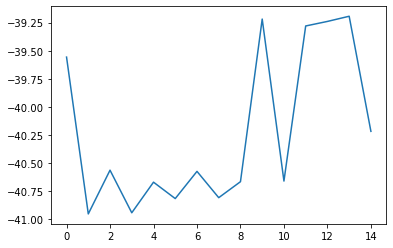

In [12]:
print(np.max(Evidence), pairs[np.argmax(Evidence)])
plt.plot(Evidence)

In [13]:
#Evidence_table = pd.DataFrame([np.array(pairs),Evidence], columns = ['Evidence', 'Predictors'])
model_evidence = pd.DataFrame([[a,b] for a,b in zip(pairs,Evidence)], 
                              columns = ['Predictors','Evidence']).sort_values('Evidence', axis = 0, 
                                                                               ascending = False)
model_evidence.head()

,Predictors,Evidence
13,"[Petrol_fraction, Total_Cars]",-39.193202
9,"[Total_Cars, UK_Population]",-39.218405
12,"[P_D, Petrol_fraction]",-39.239388
11,"[P_D, UK_Population]",-39.279928
0,"[All_EV, EV_fraction]",-39.557189


In [14]:
import statsmodels.api as sm
predictors = ['Total_Cars', 'Petrol_fraction']
# predictors = ['UK_Population', 'All_EV']
# predictors = ['UK_Population', 'P_D']
# predictors = ['UK_Population', 'EV_fraction']
y = standard_data['Total_co2']
# y = standard_data['Total_GHGs_kilotonne']
X = standard_data[predictors]
X = sm.add_constant(X) 
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Total_co2   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     31.99
Date:                Sun, 07 Mar 2021   Prob (F-statistic):           2.27e-07
Time:                        23:39:18   Log-Likelihood:                -19.601
No. Observations:                  26   AIC:                             45.20
Df Residuals:                      23   BIC:                             48.98
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             -6.8e-16      0.107  -6.34e-15      1.000      -0.222       0.222
Total_Cars          2.8979      0.417      6.943      0.000       2.034       3.761
Petrol_fraction     3.2265      0.417      7.730      0.000       2.363       4.090
==============================================================================
Omnibus:                        1.280   Durbin-Watson:                   0.699
Prob(Omnibus):                  0.527   Jarque-Bera (JB):                1.061
Skew:                           0.280   Prob(JB):                        0.588
Kurtosis:                       2.184   Cond. No.                         7.65
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
# import statsmodels.api as sm
# predictors = ['UK_Population', 'Petrol_Fraction']
# y = standard_data['Total_GHGs']
# X = standard_data[predictors]
# X = sm.add_constant(X) 
# model = sm.OLS(y, X).fit()
# model.summary()

In [16]:
# y_pred_2019 = (2.3292*1.568302+ 2.7765*(-1.475341))*std_y + mean_y

# prediction part

the linear regression is 

Y = Total_co2

<!-- Intercept =-6.8e-16

Total_cars = 2.8979

EV_Fraction = -0.4299 -->

Intercept =-6.8e-16

Total_cars = 2.8979

petrol_Fraction = 3.2265	

some assumption:

1.the linear relationship keep unchangeable during the whole period

2.the number of cars keeps the trend in the future (using arima model)


<ipython-input-17-d06b4ab50ee7>:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


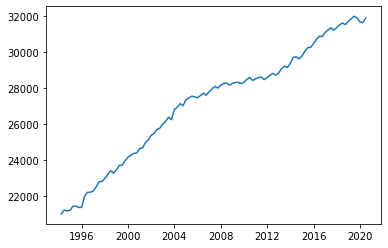

In [17]:
import pandas as pd
import numpy as np
# from pandas import read_csv
from pandas import datetime
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

main = pd.read_csv('data/data_quaterly.csv')


main['time']= pd.to_datetime(main['Quarter'].str.replace(' ','-'))#.replace()pd.to_datetime(df['Quarter'])
main.head()
main = main.set_index('time')
# main[' Cars'] = main[' Cars'].str.replace('..','')
cars = main['Cars']
cars = cars.fillna(method = 'ffill').dropna(axis=0)
cars = cars[~cars.isin(['..'])]
cars = cars.astype('float')

plt.plot(cars)

# cars_num.columns
# print(time.head())

#upward trend and some fluctuation

# autocorrelation_plot(cars)

findfont: Font family ['IPAGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['IPAGothic'] not found. Falling back to DejaVu Sans.


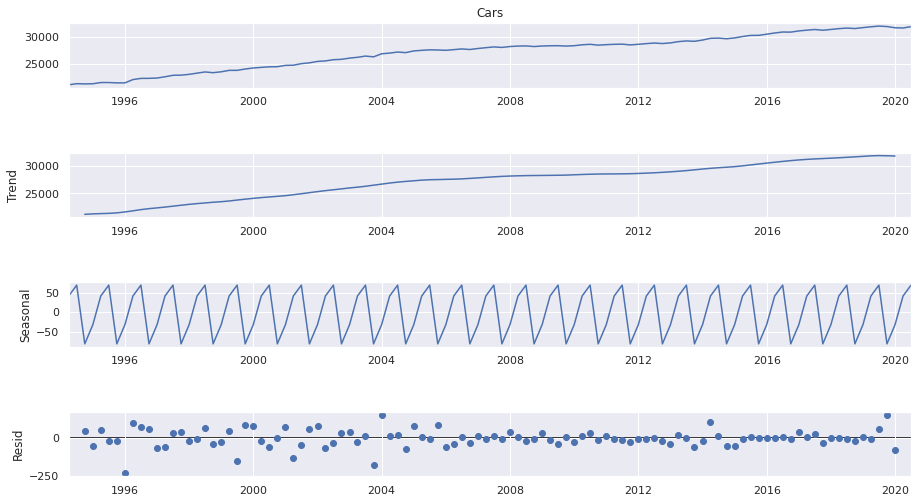

In [18]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font='IPAGothic')
import numpy as np
import statsmodels.api as sm
res = sm.tsa.seasonal_decompose(cars.dropna(),freq = 4)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()


ADF Statistic: -2.748651
p-value: 0.065991


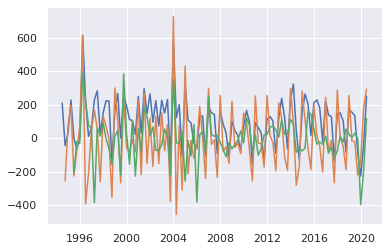

In [19]:
# check the stationarity
from statsmodels.tsa.stattools import adfuller,arma_order_select_ic
from numpy import log
car_diff_4 = cars.diff(4).dropna()
car_diff = cars.diff()[1:]

car_diff_1 = car_diff.diff().dropna()
car_diff_4 = car_diff.diff(4).dropna()
plt.plot(car_diff)
plt.plot(car_diff_1)
plt.plot(car_diff_4)
# print(car_diff)
# print(cars)

result = adfuller(car_diff)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

# The ADF Statistic is far from the critical values and the p-value is greater than the threshold (0.05). Thus, we can conclude that the time series is not stationary.


In [20]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm


model = pm.auto_arima(cars, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=1,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())
#Best model:  ARIMA(3,2,0) #p,d,q
#(1,1,0)
arma_order_select_ic(car_diff, max_ar=3, max_ma=3, ic='aic', trend='c', model_kw=None, fit_kw=None)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1341.339, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1343.393, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1345.210, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1345.104, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1385.678, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1342.873, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1347.429, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1345.381, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1343.937, Time=0.03 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1346.903, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.963 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  106
M

{'aic':              0            1            2            3
 0  1343.392582  1344.745707  1345.511549  1344.245078
 1  1344.948142  1346.262786  1347.508991  1334.985904
 2  1344.408398  1346.209529  1322.355742  1323.210544
 3  1344.810144  1333.122664  1326.612013  1313.285040,
 'aic_min_order': (3, 3)}

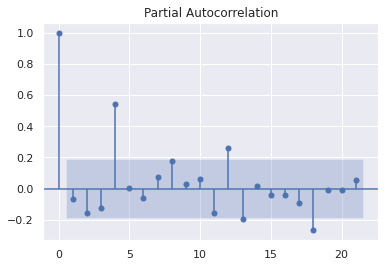

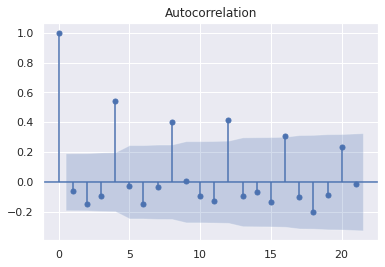

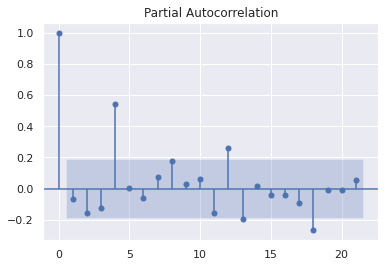

In [21]:
# plot_acf(cars)
# plot_pacf(cars)
plot_acf(car_diff)
plot_pacf(car_diff)
# plot_acf(car_diff_1)
# plot_pacf(car_diff_1)
# plot_acf(car_diff_4)
# plot_pacf(car_diff_4)

In [22]:
print(cars.tail())

time
2019-07-01    31976.2
2019-10-01    31888.4
2020-01-01    31661.4
2020-04-01    31619.2
2020-07-01    31869.4
Name: Cars, dtype: float64


                             ARIMA Model Results                              
Dep. Variable:                 D.Cars   No. Observations:                  105
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -669.131
Method:                       css-mle   S.D. of innovations            141.696
Date:                Sun, 07 Mar 2021   AIC                           1346.263
Time:                        23:39:24   BIC                           1356.879
Sample:                    07-01-1994   HQIC                          1350.565
                         - 07-01-2020                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          103.0679     12.006      8.584      0.000      79.536     126.600
ar.L1.D.Cars     0.2484      0.326      0.762      0.446      -0.390       0.887
ma.L1.D.Cars    -0.3488      0.303     -1.15

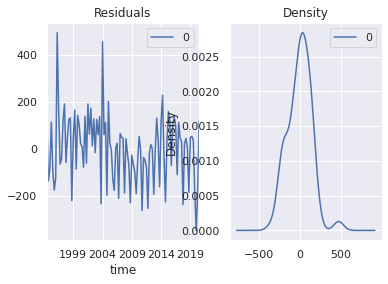

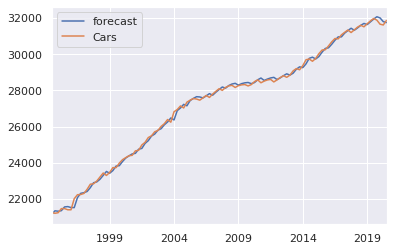

findfont: Font family ['IPAGothic'] not found. Falling back to DejaVu Sans.


                             ARIMA Model Results                              
Dep. Variable:                 D.Cars   No. Observations:                   70
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -448.142
Method:                       css-mle   S.D. of innovations            145.905
Date:                Sun, 07 Mar 2021   AIC                            902.284
Time:                        23:39:25   BIC                            909.030
Sample:                    07-01-1994   HQIC                           904.964
                         - 10-01-2011                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          106.4375     15.352      6.933      0.000      76.347     136.528
ar.L1.D.Cars    -0.1380      0.120     -1.146      0.252      -0.374       0.098
                                    Roots   

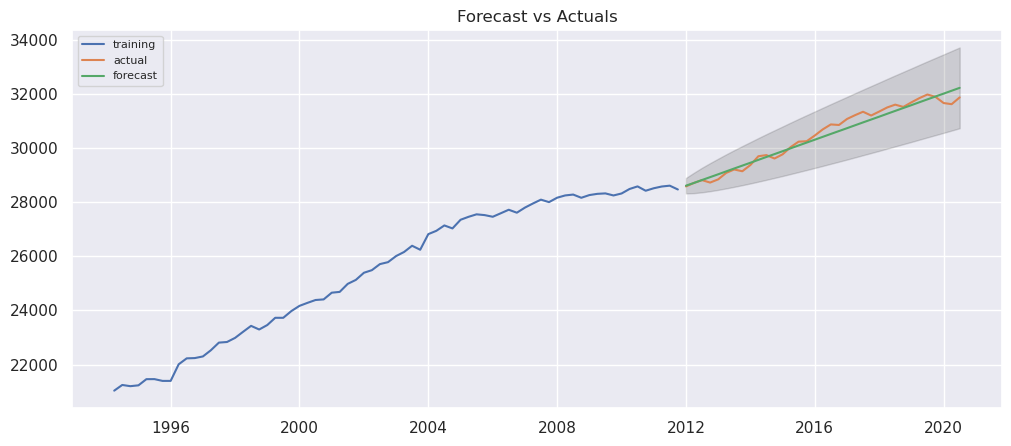

0.5671604346388712

In [23]:
#build the arima
from statsmodels.tsa.arima_model import ARIMA

# 3,2,0 ARIMA Model
model = ARIMA(cars, order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

#predict
fc, se, conf = model_fit.forecast(4*10, alpha=0.05)  # 95% conf 

#if we spilit the data as training and testing data, and calculate the MAE

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

test = cars[np.round(2/3*len(cars)).astype(int):]
train = cars[:np.round(2/3*len(cars)).astype(int)]
model = ARIMA(train, order=(1,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

# Forecast
fc, se, conf = model_fit.forecast(len(test), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
# my_x_ticks = time

# plt.xticks(my_x_ticks)

plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

mean_absolute_percentage_error(test, fc) #7.295545504861874 acceptable (3,2,0)
#if we use model (3,1,0) 0.5138645256869044
#if we use model (0,1,0) 0.5319200544501159

# print(cars.index)

In [24]:
import datetime

def create_assist_date(datestart = None,dateend = None):
	datestart=datetime.datetime.strptime(datestart,'%Y-%m-%d')
	dateend=datetime.datetime.strptime(dateend,'%Y-%m-%d')
	date_list = []
	date_list.append(datestart.strftime('%Y-%m-%d'))
	while datestart<dateend:
	    datestart+=datetime.timedelta(days = 365/4)
	    date_list.append(datestart.strftime('%Y-%m-%d'))
	return date_list

len(create_assist_date('2020-10-01','2030-10-01'))
new_index = pd.to_datetime(create_assist_date('2020-10-01','2030-09-29')) #2030-12-29 equals to the 2031-01-01
print(new_index)

DatetimeIndex(['2020-10-01', '2020-12-31', '2021-04-01', '2021-07-01',
               '2021-10-01', '2021-12-31', '2022-04-01', '2022-07-01',
               '2022-10-01', '2022-12-31', '2023-04-01', '2023-07-01',
               '2023-10-01', '2023-12-31', '2024-03-31', '2024-06-30',
               '2024-09-30', '2024-12-30', '2025-03-31', '2025-06-30',
               '2025-09-30', '2025-12-30', '2026-03-31', '2026-06-30',
               '2026-09-30', '2026-12-30', '2027-03-31', '2027-06-30',
               '2027-09-30', '2027-12-30', '2028-03-30', '2028-06-29',
               '2028-09-29', '2028-12-29', '2029-03-30', '2029-06-29',
               '2029-09-29', '2029-12-29', '2030-03-30', '2030-06-29',
               '2030-09-29'],
              dtype='datetime64[ns]', freq=None)


                             ARIMA Model Results                              
Dep. Variable:                 D.Cars   No. Observations:                  105
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -669.131
Method:                       css-mle   S.D. of innovations            141.696
Date:                Sun, 07 Mar 2021   AIC                           1346.263
Time:                        23:39:25   BIC                           1356.879
Sample:                    07-01-1994   HQIC                          1350.565
                         - 07-01-2020                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          103.0679     12.006      8.584      0.000      79.536     126.600
ar.L1.D.Cars     0.2484      0.326      0.762      0.446      -0.390       0.887
ma.L1.D.Cars    -0.3488      0.303     -1.15

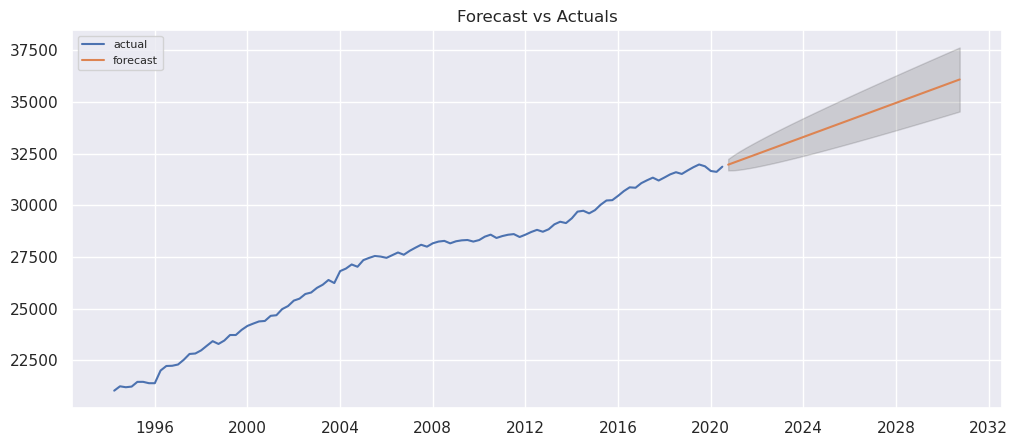

In [25]:
# test = cars[np.round(2/3*len(cars)).astype(int):]
# train = cars[:np.round(2/3*len(cars)).astype(int)]
model = ARIMA(cars, order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

# model with whole data and Forecast until 2030
fc, se, conf = model_fit.forecast(4*10+1, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=new_index)
lower_series = pd.Series(conf[:, 0], index=new_index)
upper_series = pd.Series(conf[:, 1], index=new_index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
# plt.plot(cars, label='training')
plt.plot(cars, label='actual')
plt.plot(fc_series, label='forecast')
# my_x_ticks = time

# plt.xticks(my_x_ticks)

plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

#the predicted value of number of cars at the begining of 2030 is 
predict_2030 = fc_series['2029-12-29']

## fc_year_1 is the prediction from 2020(mean of 4 quarter,only Q4 is predicted) to 2030

In [26]:
# transform the prediction of number of vehicles from quarterly to yearly

car_num_series = pd.concat([cars.iloc[[-3,-2,-1]],fc_series])
# print(car_num_series)
fc_year = []
for i in range(0, len(car_num_series), 4):
    fc_year.append(car_num_series[i:i+4])
# print(fc_year)  
fc_year_1 =[np.mean(i) for i in fc_year]
# print(len(fc_year_1))
fc_year_1 = pd.DataFrame(fc_year_1)
print(fc_year_1)

               0
0   31779.388732
1   32223.734585
2   32635.873009
3   33048.144065
4   33460.415625
5   33872.687187
6   34284.958750
7   34697.230312
8   35109.501874
9   35521.773437
10  35934.044999


In [27]:
print(cars.tail())

time
2019-07-01    31976.2
2019-10-01    31888.4
2020-01-01    31661.4
2020-04-01    31619.2
2020-07-01    31869.4
Name: Cars, dtype: float64


get the prediction for petrol fraction

If we assume that the ratio of Petrol/ (Petrol+diesel) in the following years are the same as the ratio in 2019
then the ratio is caculated by np.mean(data['Petrol']/data['P_D']),--use this one

alternatively if we assume that the ratio of Petrol/ (Petrol+diesel) in the following years are the same as average the ratio from 2001 to 2019 then the ratio is 0.601906836


get the prediction for EV fraction(not used)

assume there is a linear increase from 2020 to 2030

In [29]:
fraction = data['Petrol_fraction']
# print(fraction)

ratio = np.mean(data['Petrol']/data['P_D'])
fraction_2030 = (1-0.43)*ratio
# fraction_2030 = 0.43
fraction_2019 = fraction.loc[2019]

fraction_future = []
for i in range(11):
    fraction = fraction_2019 + (i+1)*(fraction_2030-fraction_2019)/11
    fraction_future.append(fraction)
    
print(len(fraction_future))  
fraction_future = pd.DataFrame(fraction_future)

11


the linear regression is 

Y = Total_co2

<!-- Intercept =-6.8e-16

Total_cars = 0.1124

EV_Fraction = -0.4299 -->

Intercept =-6.8e-16

Total_cars = 2.8979

petrol_Fraction = 3.2265	

In [30]:
Intercept = -6.8e-16
beta_Total_Vehicles =  2.8979
beta_petrol_Fraction = 3.2265
Intercept =pd.DataFrame([Intercept]*11)

std_total_vehicle = std_mat['Total_Cars']
mean_total_vehicle = mean_mat['Total_Cars']
std_petrol_f = std_mat['Petrol_fraction']
mean_petrol_f = mean_mat['Petrol_fraction']

std_y = std_mat['Total_co2']
mean_y = mean_mat['Total_co2']



y = Intercept+ beta_Total_Vehicles*(fc_year_1-mean_total_vehicle)/std_total_vehicle +beta_petrol_Fraction *(fraction_future-mean_petrol_f)/std_petrol_f

y_unstandardize = y*std_y+mean_y
print(y)
print(y_unstandardize)
# print(fraction_future)



            0
0  -28.772439
1  -28.995204
2  -29.217994
3  -29.440784
4  -29.663574
5  -29.886364
6  -30.109154
7  -30.331943
8  -30.554733
9  -30.777523
10 -31.000313
              0
0   2339.854879
1   2118.090496
2   1896.301129
3   1674.511864
4   1452.722600
5   1230.933335
6   1009.144071
7    787.354807
8    565.565543
9    343.776279
10   121.987014


y_unstandardize is the prediction of Total_GHGs from 2020 to 2030

try arimax

refer to https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html

https://www.kaggle.com/poiupoiu/how-to-use-sarimax

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  106
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -668.000
Date:                Sun, 07 Mar 2021   AIC                           1346.000
Time:                        23:40:00   BIC                           1359.270
Sample:                             0   HQIC                          1351.377
                                - 106                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5795   5.47e+04  -1.06e-05      1.000   -1.07e+05    1.07e+05
x1          -314.7092   2537.484     -0.124      0.901   -5288.086    4658.668
ar.L1          0.9968      0.006    161.734      0.0

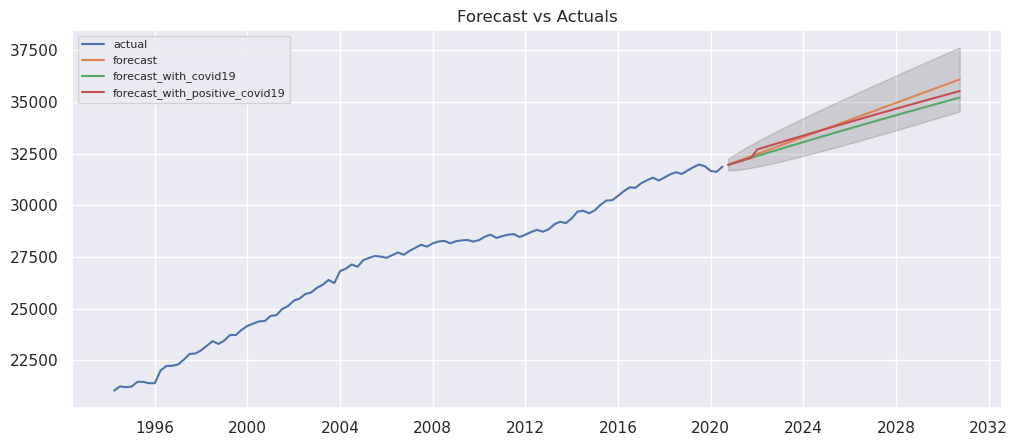

In [32]:
data = pd.DataFrame(data=cars, index=cars.index, columns=['covid'])
data['time']=data.index
# print(data)
#30-01-2020 we assume that it start from the first quarter of 2020 in UK
date_point = pd.to_datetime('2020Q1')

data.loc[(data['time'] >= date_point), 'covid'] = 1;
data.loc[(data['time'] < date_point), 'covid'] = 0;
# print(data)
covid = data['covid']
# print(covid)

#if we assume the covid-19 will affect UK until 2030
covid_future = np.ones([41,2])
# print(covid_future)
# print(pd.DataFrame(np.ones([41,2])))

#if we assume the affect will be be removed from 2021Q4, as the new lock down plan said step four june 2021 remove all legal limits on social contact
covid_positive_future = np.ones([5,2])
a = np.ones([36,1])
b = np.zeros([36,1])
m = np.concatenate((a,b),axis=1)
covid_positive = np.concatenate((covid_positive_future,m),axis=0)


import numpy as np
import pandas as pd
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
import requests
from io import BytesIO
# Variables
endog = cars
exog = sm.add_constant(covid)
endog = np.array(endog, dtype=float)
exog  = np.array(exog , dtype=float)
# Fit the model
mod = sm.tsa.statespace.SARIMAX(endog,exog, order=(1,1,1))
res = mod.fit(disp=False)
print(res.summary())

fc_covid = res.forecast(exog=covid_future ,steps=4*10+1, alpha=0.05)
# fcast_res2 = res.get_forecast(steps=2)
fc_covid_pos = res.forecast(exog=covid_positive ,steps=4*10+1, alpha=0.05)

# Make as pandas series
fc_series_covid = pd.Series(fc_covid, index=new_index)
fc_series_covid_pos = pd.Series(fc_covid_pos, index=new_index)
# Plot
plt.figure(figsize=(12,5), dpi=100)
# plt.plot(cars, label='training')
plt.plot(cars, label='actual')
plt.plot(fc_series, label='forecast')
plt.plot(fc_series_covid, label='forecast_with_covid19')
plt.plot(fc_series_covid_pos, label='forecast_with_positive_covid19')
# my_x_ticks = time

# plt.xticks(my_x_ticks)

plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

